# Results Plots:

### Authors : Daniel (UFRN), Vicente Sousa (UFRN) and Ricardo Queiroz (UFRN)

## Directory

In [5]:
# Changing Working Directory - Linux
script_path = '/home/oai-ufrn/Repositories/open_ran_datacenter_placement/PlotScripts'
%cd $script_path

/home/oai-ufrn/Repositories/open_ran_datacenter_placement/PlotScripts


## Script

In [6]:
%%file PlotCampaignScript.py
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
import scipy.stats as st
import os
import argparse
import yaml
import matplotlib
from random import randint   
import itertools
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.gridspec as gridspec
import pandas as pd
import csv

class openSimulation:
    def __init__(self, configurations_file, save_path, campaign_path):
        self.email_to = 'fulano@gmail.com'            
        self.doc = []
        self.campaign_name = []
        self.configurations_file=[]
        for iconfigurations_file in range(len(configurations_file)):
            os.chdir(campaign_path[iconfigurations_file])
            with open(configurations_file[iconfigurations_file], 'r') as f:
                self.doc = np.append(self.doc,yaml.load(f, Loader=yaml.loader.BaseLoader))
                self.campaign_name = np.append(self.campaign_name ,os.path.splitext(configurations_file[0])[0])
                self.configurations_file = np.append(self.configurations_file,configurations_file)
                 
        # Simu parameters
        self.commandScriptList = []
        self.script = []
        self.local_path = []
        self.save_path = []
        self.campaign_path = []
        self.cluster_path = []
        self.outputDirName = []
        self.outputDir = []
        self.seed = []
        self.CampaignTag = []
        self.configurations_file = configurations_file
        self.simLocation = []
        self.nOfCurlines = []
        self.SimTied = []
        self.nOfCurlinesTied = []
        self.daytime = []
        self.htime = []
        self.ntasks = []
        self.cpusPerTask = []
        self.numberOfJobsShellScript = []
        self.campaignX = []
        self.campaignLines = ['']*len(self.doc)
        self.nJobs = []
        for idoc in range (len(self.doc)):
            os.chdir(campaign_path[idoc])
            self.commandScript = ''
            for iscenarioParameters in self.doc[idoc]['scenarioParameters'].items():
                commandraw= " --"+str(iscenarioParameters[0])+"="+str(iscenarioParameters[1][0])
                self.commandScript = self.commandScript + commandraw
            self.commandScriptList = np.append(self.commandScriptList, self.commandScript)

            # ns-3 script configuration
            self.script = np.append(self.script,str(self.doc[idoc]['ScriptParameters']['script']))
            self.local_path = np.append(self.local_path, str(self.doc[idoc]['ScriptParameters']['local_path']))
            self.campaign_path = np.append(self.campaign_path,os.getcwd())
            self.save_path = np.append(save_path,save_path)
            
            #self.local_path = os.getcwd() + '/' + self.local_path
            self.cluster_path = np.append(self.cluster_path,str(self.doc[idoc]['ScriptParameters']['cluster_path']))
            self.outputDirName = np.append(self.outputDirName,str(self.doc[idoc]['ScriptParameters']['outputDir'][0]))
            self.outputDir = np.append(self.outputDir,str(self.doc[idoc]['ScriptParameters']['outputDir'][1]))
            self.seed = np.append(self.seed,str(self.doc[idoc]['ScriptParameters']['seed']))
            self.CampaignTag = np.append(self.CampaignTag,str(self.doc[idoc]['ScriptParameters']['CampaignTag']))
            self.configurations_file = configurations_file       
            self.simLocation = np.append(self.simLocation,str(self.doc[idoc]['ScriptParameters']['simLocation']))
    
            # Shell Script Parameters configuration
            self.nOfCurlines = np.append(self.nOfCurlines,self.doc[idoc]['ShellScriptParameters']['nOfCurlines'])
            self.SimTied = np.append(self.SimTied,self.doc[idoc]['ShellScriptParameters']['SimTied'])
            self.nOfCurlinesTied = np.append(self.nOfCurlinesTied,self.doc[idoc]['ShellScriptParameters']['nOfCurlinesTied'])
            self.daytime = np.append(self.daytime,self.doc[idoc]['ShellScriptParameters']['daytime'])
            self.htime = np.append(self.htime,self.doc[idoc]['ShellScriptParameters']['htime'])
            self.ntasks = np.append(self.ntasks,self.doc[idoc]['ShellScriptParameters']['ntasks'])
            self.cpusPerTask = np.append(self.cpusPerTask,self.doc[idoc]['ShellScriptParameters']['cpusPerTask'])
            self.numberOfJobsShellScript = np.append(self.numberOfJobsShellScript,int(self.doc[idoc]['ShellScriptParameters']['numberOfJobsShellScript']))
            
            #Lines/curves
            self.campaignX = np.append(self.campaignX,self.doc[idoc]['campaignLines']['campaignX'])
            self.campaignLines[idoc] = self.doc[idoc]['campaignLines']['campaignLines']
            self.nJobs = np.append(self.nJobs, int(self.doc[idoc]['campaignLines']['jobs']))
            
        #Plot parameters
        self.showPlot = True;
        self.plotCI = False; 
        self.reverse = False; # reverse x and y arrays of the graphs.
        #self.MetricsCentralCell = True;
      
    def plotCampaign(self,metric,jobs,metricAggregated,lgraphs):#,fig1,fig2,fig3,fig4):
        m_plr, m_plrCI, m_tput, m_tputCI, m_pkt = [], [], [], [], []
        m_delay =[]
        m_plrcdf,m_tputcdf,m_pktcdf,m_delaycdf=[],[],[],[]
        legend=[]
        legendCdf = []
        legendCdfWithoutCG= []
        npmetric = [[0,0]]
        markers_on_all = cycle(list(itertools.product([0], [1,2,3,4,5])))
        markersA = cycle(('o','v', 'D', '>', 'h', '^', '*', '>', 's', 'H', 'D', 'd'))
        colors = cycle(('b', 'g', 'r', 'c', 'm', 'y', 'k'))
        colors = cycle(('b', 'g', 'r', 'c'))
        linestyle = cycle(('-', '--'))# '-.', ':'))
        ls_plotly = cycle(("solid","dot","dash","longdash","dashdot","longdashdot")) 
        markers_on=next(markers_on_all)
        marker=next(markersA)        
        color=next(colors)
        linestyle_on =next(linestyle)
        ls_plotly_on = next(ls_plotly)
        iCampaignSim = 0 #counter of number of total curves, it should be len(doc)*len(self.doc[idoc]['scenarioParameters'][curLine]) 
        for idoc in range(len(doc)):    # for each campaing passed
            resultsDir = self.campaign_path[idoc]
            outputDir = self.save_path[idoc]
            njobs = min(jobs,self.nJobs[idoc])
            nOfCurlines=int(self.nOfCurlines[idoc]) # number of Campaign Lines in 1 simulation (max value = 3)
            SimTied = int(self.SimTied[idoc]) # whether or not the simulation parameters are tied (0 or 1)
            nOfCurlinesTied = int(self.nOfCurlinesTied[idoc]) # number of Campaign Lines tied (max value = nOfCurlines)
            
            print ("Config.Plot: ",nOfCurlines,SimTied,nOfCurlinesTied)
            
            if nOfCurlines==3 and SimTied == 1 and nOfCurlinesTied == 3:
                legendEE = [] 
                legendCdfWithoutCG= []
                window=0.1
                curLine = self.campaignLines[idoc][0]
                curLine1 = self.campaignLines[idoc][1]
                curLine2 = self.campaignLines[idoc][2]
                campaignX = self.campaignX[idoc]
                nCurlines = len(self.doc[idoc]['scenarioParameters'][curLine])
                if idoc == 0: # variables will not restart when calculating the next campaign
                    rowsTotal=0    
                    for iidoc in range(len(doc)):
                        if self.SimTied[iidoc] == '0':
                            ncurlines = int(self.nOfCurlines[iidoc])
                            if ncurlines == 1:
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif ncurlines == 2:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])
                                rowsTotal += rows
                            elif ncurlines == 3:
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc1 = self.campaignLines[iidoc][1]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc1])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                        else:
                            if (self.nOfCurlines[iidoc] == '2' and self.nOfCurlinesTied[iidoc] == '2') or (self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '3'):
                                curLineDoc = self.campaignLines[iidoc][0]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '3' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '4' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])
                                rowsTotal += rows
                            elif self.nOfCurlines[iidoc] == '5' and self.nOfCurlinesTied[iidoc] == '2':
                                curLineDoc = self.campaignLines[iidoc][0]
                                curLineDoc2 = self.campaignLines[iidoc][2]
                                curLineDoc3 = self.campaignLines[iidoc][3]
                                curLineDoc4 = self.campaignLines[iidoc][4]
                                rows = len(self.doc[iidoc]['scenarioParameters'][curLineDoc])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc2])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc3])*len(self.doc[iidoc]['scenarioParameters'][curLineDoc4])
                                rowsTotal += rows
                            # if more configurations are implemented, it is necessary to also implement here
                    
                    df_metricSytemcdf = pd.DataFrame()
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]
                    mm_metricSystem = np.zeros((rowsTotal,len(self.doc[idoc]['scenarioParameters'][campaignX])))
                    
                xlabel= campaignX
                curlineLegend = self.doc[idoc]['scenarioParameters'][curLine]
                curlineLegend1 = self.doc[idoc]['scenarioParameters'][curLine1]
                curlineLegend2 = self.doc[idoc]['scenarioParameters'][curLine2]
                for ilegend in range(len(self.doc[idoc]['scenarioParameters'][curLine])):
                    legendEntry = self.CampaignTag[idoc] + ": " + curLine + " " + curlineLegend[ilegend] + ", " + curLine1 + " " + curlineLegend1[ilegend] + ", " + curLine2 + " " + curlineLegend2[ilegend]
                    legend.append(legendEntry)
                    for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                        legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                        legendCdf.append(legendCdfEntry)
    
                #legend without CampaignTag        
                for ilegend in self.doc[idoc]['scenarioParameters'][curLine]:
                    legendEntry = curLine + " " + ilegend
                    #legend.append(legendEntry) 
                    for ilegendcdf in self.doc[idoc]['scenarioParameters'][campaignX]:
                        legendCdfEntry = legendEntry + "," + " " + campaignX + " " + ilegendcdf 
                        legendCdfWithoutCG.append(legendCdfEntry)        
                        
                labelA = cycle(legend)
                labelAcdf = cycle(legendCdf)
                labelAPC = cycle(legendEE)
                
                
            else: 
                print ("to be implemented")
              
            ###################### Metric Calculation Section #####################################
            isim = 0
            for iCurlines in range(nCurlines):
                for iCampaignX in range(len(self.doc[idoc]['scenarioParameters'][campaignX])):                    
                    vtmetric = [] #for IP metrics
                    dfmetric = pd.DataFrame() # for PHY metrics
                    nUes = 0
                    for iJob in range(0,njobs):
                        if metric.split('-')[0] == "Capacity":
                            CurSimuFile = resultsDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/df_capacities.csv"
                            dfmetricA = pd.read_csv(CurSimuFile, usecols=['odc_locations', 'capacities'])
                            column = 'capacities'
                            dfmetric = pd.concat([dfmetric, dfmetricA], ignore_index=True)
                            ylabel = 'Capacity (CPUs/ODC)'
                            xlabelcdf = "(CPUs/ODC)"
                            #print(CurSimuFile)
                        elif metric.split('-')[0] == 'Fiberlength':
                            CurSimuFile = resultsDir +"/JOB"+str(iJob)+"/Sim_"+str(isim)+"/df_fiberlength.csv"
                            dfmetricA = pd.read_csv(CurSimuFile, usecols=['odc_locations', 'fiberlength'])
                            column = 'fiberlength'
                            dfmetric = pd.concat([dfmetric, dfmetricA], ignore_index=True)
                            ylabel = 'Fiberlength (kms)'
                            xlabelcdf = "(kms)"
                            #print(CurSimuFile)

                    #Getting Overall Metrics        
                    if metric.split('-')[1] == 'System':
                        MetricMean=dfmetric[column]
                        vtMetricMeanSystem = np.append(vtMetricMeanSystem,MetricMean)
                        vtMetricMeanSystem = vtMetricMeanSystem[~np.isnan(vtMetricMeanSystem)]
                        dfMetricMeanSystem = pd.DataFrame(vtMetricMeanSystem)
                        
                        if len(metric.split('-')) <= 2:
                            mm_metricSystem[iCampaignSim,iCampaignX] = np.mean(vtMetricMeanSystem) # Mean of Metrics
                        elif len(metric.split('-')) > 2:
                            df_metricSytemcdf = pd.concat([df_metricSytemcdf,dfMetricMeanSystem],axis=1) ## CDF
         
                    #print(isim)    
                    #Calculate CI
                    isim += 1
                    l, hplr = st.t.interval(0.95, len(m_plr), loc=np.mean(m_plr), scale=st.sem(m_plr))
                    l, htput = st.t.interval(0.95, len(m_tput), loc=np.mean(m_tput), scale=st.sem(m_tput))
                    l, hpkt = st.t.interval(0.95, len(m_pkt), loc=np.mean(m_pkt), scale=st.sem(m_pkt))
    
                    vtMetricMeanUser,vtMetricMeanBwp,vtMetricMeanSystem,vtMetricMeanIP=[],[],[],[]
                iCampaignSim +=1

        ################# Start of Curve Plotting Section #################
        # Define Labels            
        resxData = self.doc[idoc]['scenarioParameters'][campaignX]
        label = next(labelA)
        labelcdf = next(labelAcdf)
        datarxpkt=[]
        datatputcdf=[]
        datapktcdf=[]
        
        # Plot Parameters
        bins = 1000
        count=0
        # Plot variables must be set before this section 
        if len(metric.split('-')) > 2:
            if metric.split('-')[2] == 'CDF': # CDF plots
                if metric.split('-')[1] == "System":
                    df_metricCdf = df_metricSytemcdf
                
                # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                x=0
                count = 0
                ylabel= metric
                xlabelcdf = metric.split('-')[0] + " " + xlabelcdf
                #plt.figure(figsize=(40,10))
                #figCdfTput, f2_axes = plt.subplots(ncols=1, nrows=int(df_metricSytemcdf.shape[1]/4), constrained_layout=True,figsize=(10,30))
                if metricAggregated == 'Curline':
                    figCdfTput, f2_axes = plt.subplots(ncols=1, nrows=int(np.ceil(df_metricCdf.shape[1]/4)), constrained_layout=True,figsize=(10,5))
                    metricTag = "_"+curLine 
                    for i in range (df_metricCdf.shape[1]):
                        if i % 4 == 0: #4 configurations
                            x+=1
                            plt.grid()
                            plt.subplot(int(df_metricCdf.shape[1]/4), 1, x)
                        resyData, resxData =np.histogram(df_metricCdf.iloc[:,i].dropna(),density=True,bins=bins)
                        cdf = np.cumsum(resyData*np.diff(resxData))
                        l, htput = st.t.interval(0.95, len(resyData), loc=np.mean(resyData), scale=st.sem(resyData))                        
                        plt.plot(resxData[1:], cdf, label=labelcdf, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                        color=next(colors)
                        marker=next(markersA)
                        markers_on=next(markers_on_all)
                        labelcdf = next(labelAcdf)
                        linestyle_on=next(linestyle)
                        plt.xlabel(xlabelcdf)
                        plt.ylabel(ylabel)
                        #plt.xlim([0.10, 0.55]) 
                        #plt.legend(loc='best', numpoints=1)
                        plt.tight_layout()
                        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    #plt.grid()
                elif metricAggregated == 'All':
                    #figCdfTput, f2_axes = plt.subplots(ncols=1, nrows=int(np.ceil(df_metricCdf.shape[1]/4)), constrained_layout=True,figsize=(10,5))
                    f2_axes = plt.figure(figsize=(10,5))
                    metricTag = "_AllCurves" 
                    for i in range (df_metricCdf.shape[1]):
                        resyData, resxData =np.histogram(df_metricCdf.iloc[:,i].dropna(),density=True,bins=bins)
                        cdf = np.cumsum(resyData*np.diff(resxData))
                        l, htput = st.t.interval(0.95, len(resyData), loc=np.mean(resyData), scale=st.sem(resyData))                        
                        #plt.plot(resxData[1:], cdf, label=labelcdf, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                        plt.plot(resxData[1:], cdf, label=labelcdf, color=color,ls=linestyle_on)
                        trace1 = go.Scatter(
                            x=resxData,
                            y=cdf,
                            name=labelcdf,
                            line_dash=ls_plotly_on,
                            marker_symbol=markers_on
                        )
                        datapktcdf.append(trace1)
                        color=next(colors)
                        marker=next(markersA)
                        markers_on=next(markers_on_all)
                        labelcdf = next(labelAcdf)
                        #linestyle_on=next(linestyle)
                        ls_plotly_on = next(ls_plotly)
                        if i == df_metricCdf.shape[1]/2  - 1:
                            linestyle_on=next(linestyle)                
                        plt.xlabel(xlabelcdf)
                        plt.ylabel(ylabel)
                        #plt.xlim([0.10, 0.55]) 
                        #plt.legend(loc='best', numpoints=1)
                        plt.tight_layout()
                        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                    plt.grid()
                        #plt.show()
                    layout = go.Layout(
                        yaxis=dict(
                            domain=[0, 1]
                        ),
                        legend=dict(
                            traceorder="normal"
                        ),
                        xaxis_title=xlabelcdf,
                        yaxis_title=ylabel
                        )
                    fig = go.Figure(data=datapktcdf, layout=layout)    
        else:            
            if metric.split('-')[1] == "System":
                # Confidence interval according to https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
                plt.figure(figsize=(10, 5))
                #plt.subplot(3, 1, 3)
                ylabel="System " + ylabel
                mm_metricplot = mm_metricSystem
                
            if bool(self.plotCI):                
                for i in range (mm_metricplot.shape[0]):
                    #resxData = np.linspace(1,njobs,len(dfMeanRxPkt.iloc[:,i].expanding().mean()))
                    resyData = mm_metricplot[i,:]
                    if (self.reverse):
                        resyData.reverse()
                        resxData.reverse()
                    l, htput = st.t.interval(0.99, len(resyData), loc=np.mean(resyData), scale=st.sem(resyData))                        
                    plt.plot(resxData, resyData, label=label, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                    plt.errorbar(resxData,resyData, yerr = (htput-resyData), marker=marker,color=color, ls = 'none', lw = 2, capthick = 2,markevery=markers_on)
                    trace1 = go.Scatter(
                        x=resxData,
                        y=resyData,
                        error_y=dict(type='data', # value of error bar given in data coordinates
                                    array=(htput-resyData),
                                    visible=True),
                        name=label,
                        line_dash=ls_plotly_on,
                        marker_symbol=markers_on
                    )
                    datarxpkt.append(trace1)
                    color=next(colors)
                    marker=next(markersA)
                    markers_on=next(markers_on_all)
                    label = next(labelA)
                    linestyle_on=next(linestyle)
                    ls_plotly_on = next(ls_plotly)
                layout = go.Layout(
                    yaxis=dict(
                        domain=[0, 1]
                    ),
                    legend=dict(
                        traceorder="normal"
                    ),
                    xaxis_title=xlabel,
                    yaxis_title=ylabel
                    )
                fig = go.Figure(data=datarxpkt, layout=layout)

            else:
                if (self.reverse):
                    resxData.reverse()
                    mm_metricplot = np.flip(mm_metricplot, axis=1)
                for i in range (mm_metricplot.shape[0]):
                    resyData = mm_metricplot[i,:]    
                    plt.plot(resxData,resyData, label=label, marker=marker,color=color,markevery=markers_on,ls=linestyle_on)
                    trace1 = go.Scatter(
                        x=resxData,
                        y=resyData,
                        name=label,
                        line_dash=ls_plotly_on,
                        marker_symbol=markers_on
                    )
                    datarxpkt.append(trace1)
                    color=next(colors)
                    marker=next(markersA)
                    markers_on=next(markers_on_all)
                    label = next(labelA)
                    linestyle_on=next(linestyle)
                    ls_plotly_on = next(ls_plotly)
                layout = go.Layout(
                    yaxis=dict(
                        domain=[0, 1]
                    ),
                    legend=dict(
                        traceorder="normal"
                    ),
                    xaxis_title=xlabel,
                    yaxis_title=ylabel
                    )
                fig = go.Figure(data=datarxpkt, layout=layout)
            
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            #plt.xlim([0.10, 0.55]) 
            #plt.legend(loc='best', numpoints=1)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid()
            plt.tight_layout()
            #plt.show()dict(color=colors_list[:len(resxData)])
            
        
        
        # Plot figure
        #params = {'legend.fontsize': 'x-large',
        # 'axes.labelsize': 'x-large',
        # 'axes.titlesize':'x-large',
        # 'xtick.labelsize':'x-large',
        # 'ytick.labelsize':'x-large'}
        #plt.rcParams.update(params)  
        commandTag = ''
        for idoc in range (len(doc)):
            commandraw= self.CampaignTag[idoc] +"_"
            commandTag = commandTag + commandraw 
        
        if len(doc) > 1:
            commandTag = str(len(doc))
        else:
            commandTag = ''
        os.makedirs(outputDir+campaign_path[idoc].split('/')[-2]+"/png", exist_ok=True)
        os.makedirs(outputDir+campaign_path[idoc].split('/')[-2]+"/html", exist_ok=True)
        if len(metric.split('-')) > 2 and metric.split('-')[2] == "CDF":
            imgfilename = commandTag + metric + metricTag +'_' +campaignX
        else:
            imgfilename = commandTag + metric +'_' +campaignX
        
        plt.savefig(outputDir+campaign_path[idoc].split('/')[-2]+"/png/"+imgfilename+".png")
        if metricAggregated == 'All':
            pio.write_html(fig, file=outputDir+campaign_path[idoc].split('/')[-2]+"/html/"+imgfilename+'.html', auto_open=True)
        if bool(self.showPlot):
            plt.show()
            if metricAggregated == 'All':
                fig.show()
        else:
            plt.close()
            
        ## Saving data into .csv file
        os.makedirs(outputDir+campaign_path[idoc].split('/')[-2]+"/data", exist_ok=True)
        if len(metric.split('-')) > 2:
            df_metricCdf.columns = legendCdf
            df_metricCdf.to_csv(outputDir+campaign_path[idoc].split('/')[-2]+"/data/"+commandTag+ylabel+".csv")
        else:
            df_metric=pd.DataFrame(mm_metricplot,index=legend)
            dfResxData=pd.DataFrame(resxData,columns=['x']).transpose()
            df_metric=pd.concat([df_metric,dfResxData])
            df_metric.to_csv(outputDir+campaign_path[idoc].split('/')[-2]+"/data/"+metric+".csv")
            #np.savetxt(outputDir+"/data/"+ylabel+".csv", mm_metricplot, delimiter=",")

parser = argparse.ArgumentParser()
#parser = "CaNR_campaign.yaml"
parser.add_argument("-f", "--file", type=str, nargs='+', help='Configuration File')
parser.add_argument("-g", "--graphs", type=str, default='System',help='Graphs:"System" or "User"')
parser.add_argument("-j", "--jobs", type=str, help='The script will ignore the value in .yaml')
parser.add_argument("-m", "--metricAggregated", type=str, default='All' ,help='Metric that will be used to aggregate the curves; Curline or Campaign or CampaignX or All')
parser.add_argument("-l", "--layerGraphs", type=str, default='PHY',help='Layer from which the results will be plotted; PHY or IP or ALL')
parser.add_argument("-t", "--typeGraphs", type=str, default='mean',help='Type of graph: mean, CDF or ALL')
parser.add_argument("-p", "--campaign_path", type=str, nargs='+', help='Path')
parser.add_argument("-sp", "--save_path", type=str, nargs='+', help='Save Path')
#parser.add_argument("-p", "--path", type=str, help='Path')
#parser.add_argument("-s", "--simtime", type=str, help='Value script will use as start to to plot figures in "s"')
#parser.add_argument("-sm", "--simtimeMax", type=str,default='100',help='Value script will use as end to plot figures in "s"')

args = parser.parse_args()
configurations_file = args.file
graph= args.graphs
jobs = int(args.jobs)
metricAggregated = args.metricAggregated
campaign_path = args.campaign_path
save_path = args.save_path
#Ssimtime = int(args.simtime) 
#SsimtimeMax = int(args.simtimeMax) 
lgraphs = args.layerGraphs
tGraphs = args.typeGraphs

# Plot Metrics
#if plotting 2 or more campaigns, make sure the variable CampaingX is the same in both campaigns, otherwise, you should only plot CDFs for obvious reasons (2 or more different varibles with (probably) different sizes in the same axis?).
if lgraphs == 'MACRO':  
    if tGraphs == 'mean':
        finalMetrics = [
                        'Capacity-'+graph,                        
                        'Fiberlength-'+graph
                        ] 
    elif tGraphs == 'CDF':
        finalMetrics = [
                        'Capacity-'+graph+'-CDF',
                        'Fiberlength-'+graph+'-CDF'
                        ]
    elif tGraphs == 'All':
         finalMetrics = [
                         'Capacity-'+graph+'-CDF',
                         'Fiberlength-'+graph+'-CDF',
                         'Capacity-'+graph,                        
                         'Fiberlength-'+graph
                         ]

doc=[]
for iconfigurations_file in range(len(configurations_file)):
    os.chdir(campaign_path[iconfigurations_file])
    with open(configurations_file[iconfigurations_file], 'r') as f:
        doc = np.append(doc,yaml.load(f, Loader=yaml.loader.BaseLoader))
        campaign_name = os.path.splitext(configurations_file[iconfigurations_file])[0] 
        print("Campaign to plot: " + campaign_name)
        
campaign = []
for idoc in range(len(doc)):
    campaign = np.append(campaign,doc[idoc]['campaignLines']['campaignX'])

print("No. of Campaign to plot: ",len(doc))
print("Campaign: ", campaign)
print("Kind of Graph: ", metricAggregated)

for iMet in finalMetrics:
    print("Graph: ",iMet)
    simu = openSimulation(configurations_file, save_path, campaign_path)
    simu.plotCampaign(iMet,jobs,metricAggregated,lgraphs)#,fig1,fig2,fig3,fig4)
    #campaign = doc[idoc]['campaignLines']['campaignX'] 

Overwriting PlotCampaignScript.py


## Plots

### Case 4

#### Natal

/home/oai-ufrn/Repositories/open_ran_datacenter_placement/PlotScripts
Campaign to plot: Placement_Natal_Case_4
No. of Campaign to plot:  1
Campaign:  ['odcs']
Kind of Graph:  All
Graph:  Capacity-System-CDF
Config.Plot:  3 1 3


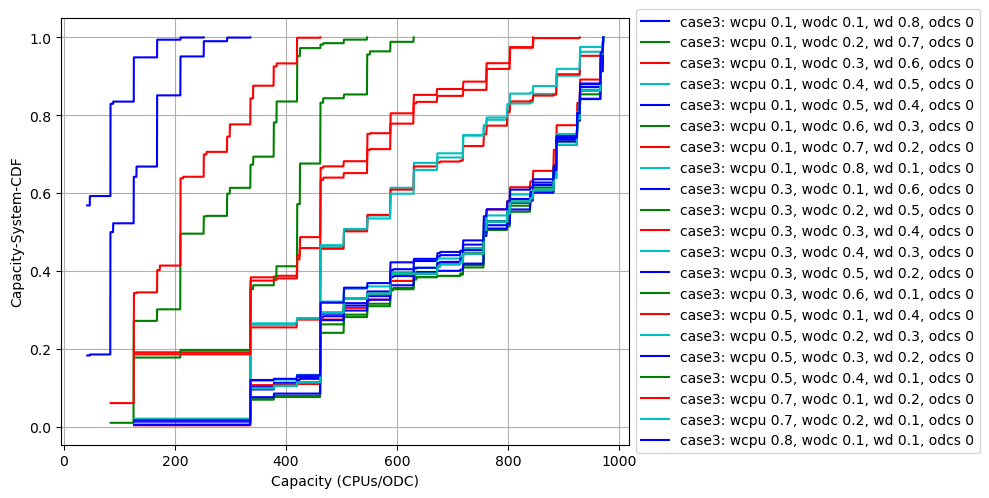

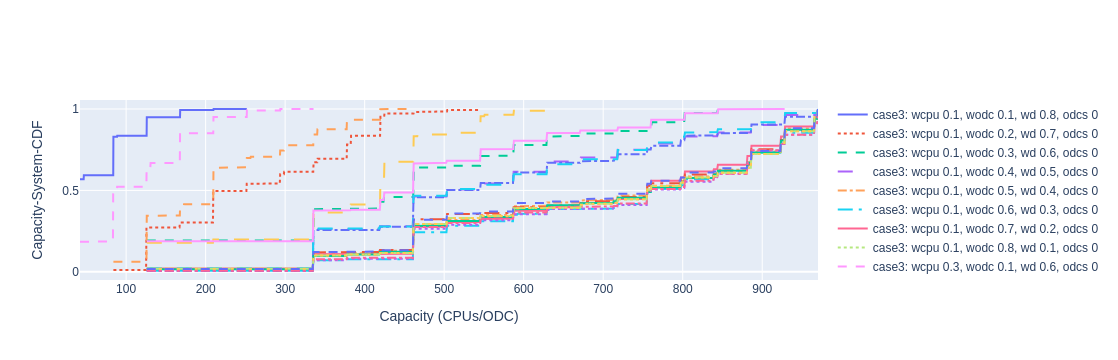

Graph:  Fiberlength-System-CDF
Config.Plot:  3 1 3


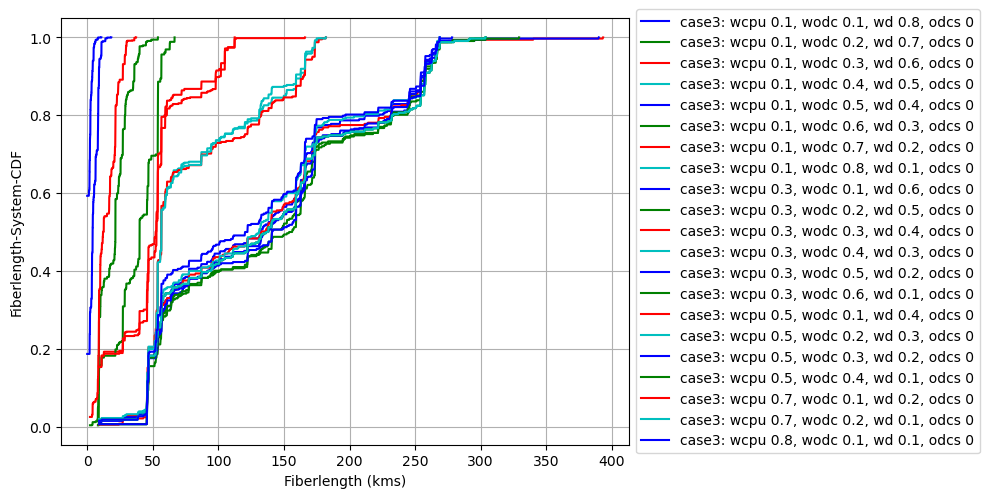

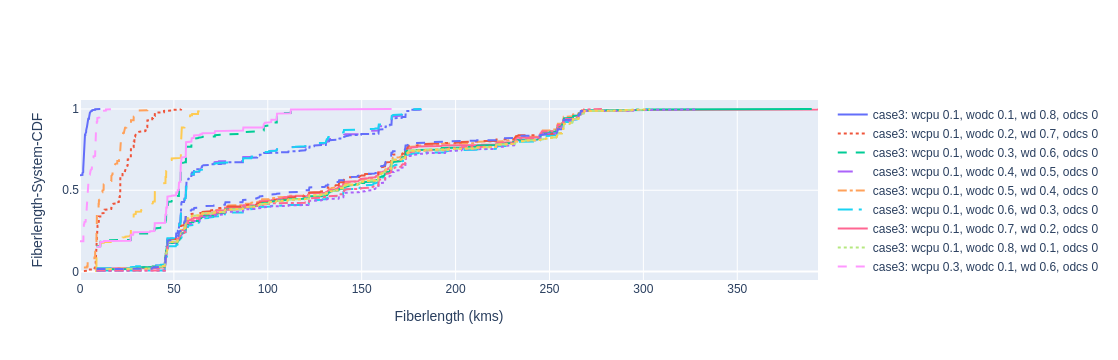

Graph:  Capacity-System
Config.Plot:  3 1 3


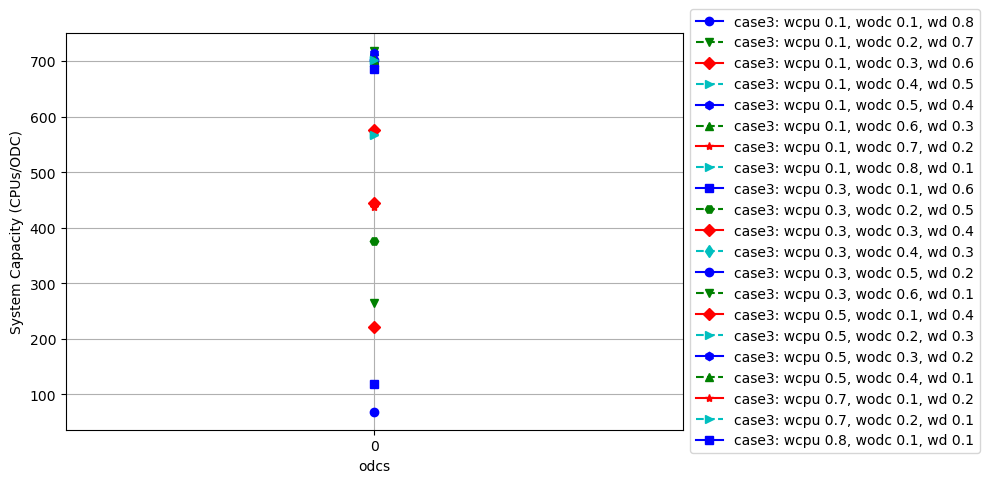

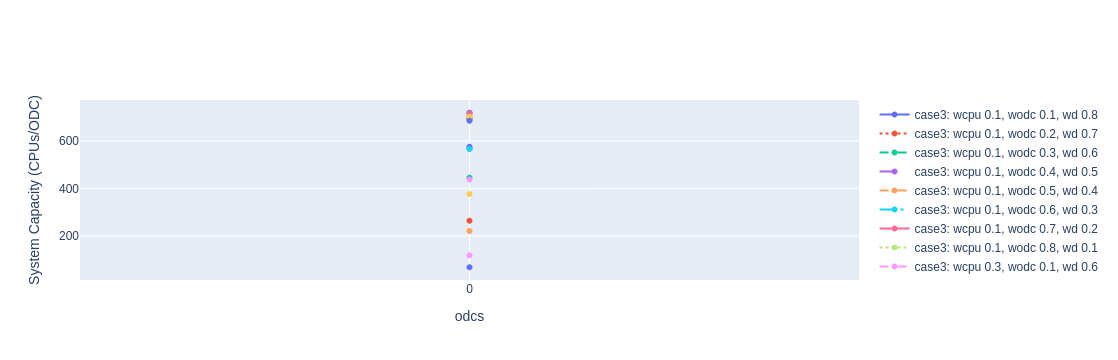

Graph:  Fiberlength-System
Config.Plot:  3 1 3


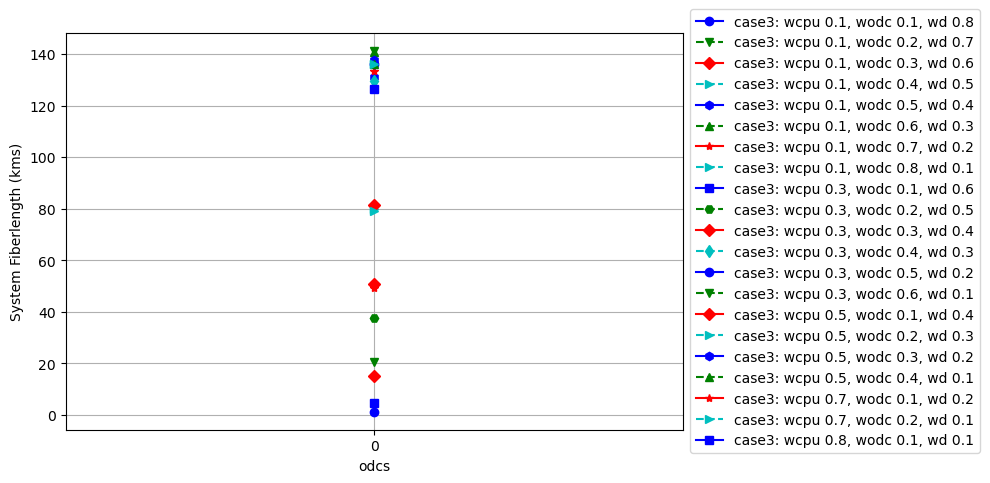

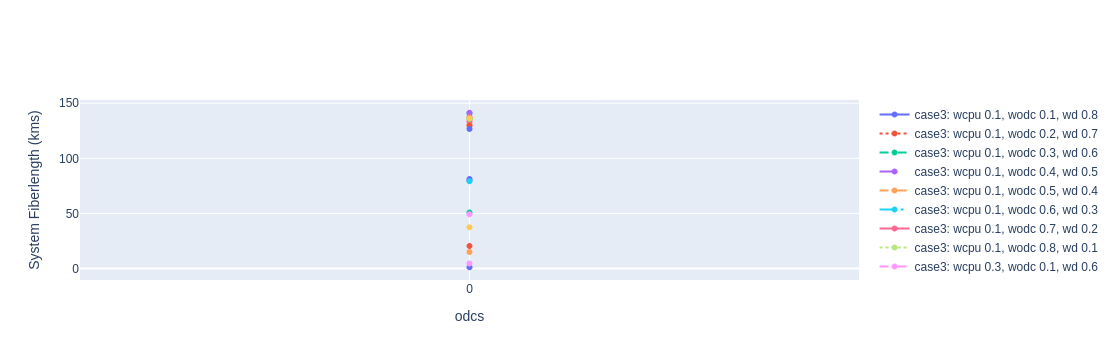

In [7]:
#Linux:
%cd $script_path
%run PlotCampaignScript -j "100" -l "MACRO" -g "System" -t "All" -m "All" -f "Placement_Natal_Case_4.yaml" -p "/home/oai-ufrn/Repositories/open_ran_datacenter_placement/Results/results_Placement_Natal_Case_4_odcs/" -sp '/home/oai-ufrn/Repositories/open_ran_datacenter_placement/PlotResults/'

#### Manaus

/home/oai-ufrn/Repositories/open_ran_datacenter_placement/PlotScripts
Campaign to plot: Placement_Manaus_Case_4
No. of Campaign to plot:  1
Campaign:  ['odcs']
Kind of Graph:  All
Graph:  Capacity-System-CDF
Config.Plot:  3 1 3


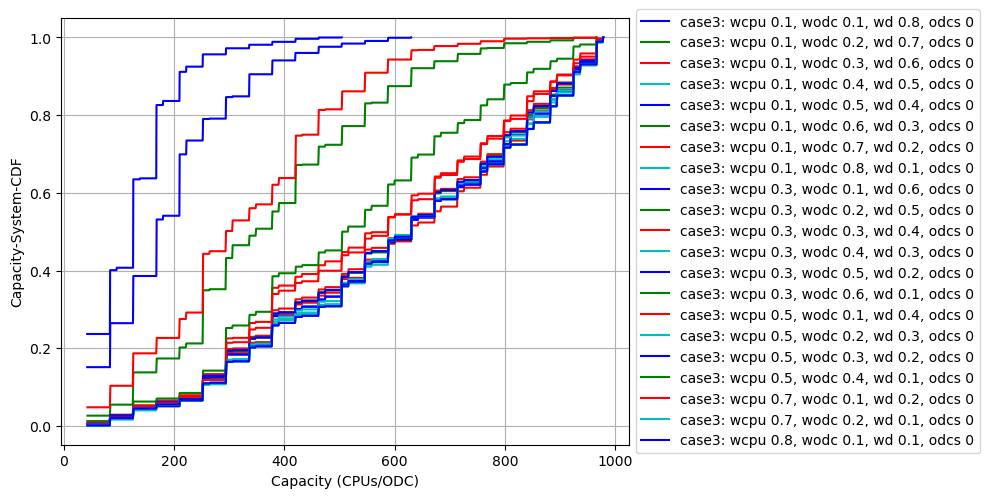

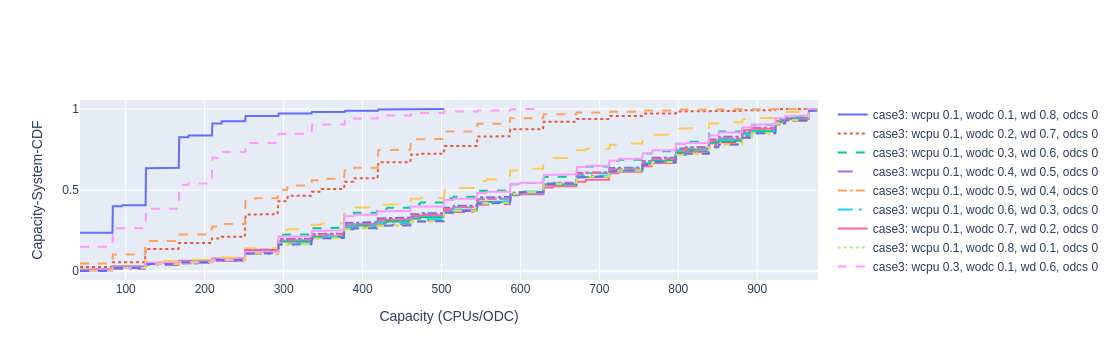

Graph:  Fiberlength-System-CDF
Config.Plot:  3 1 3


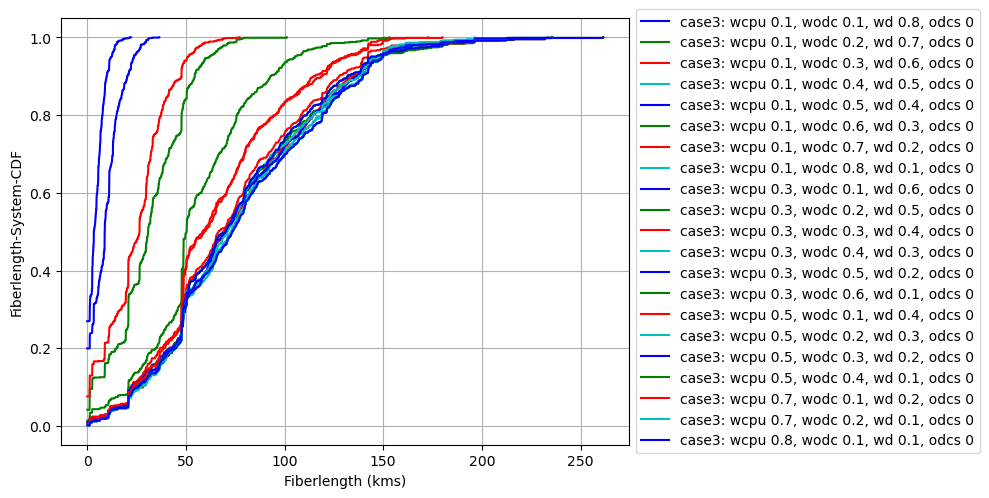

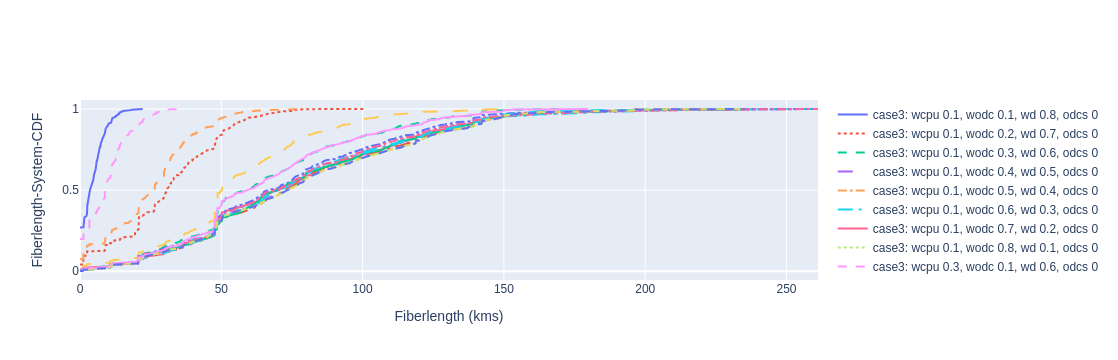

Graph:  Capacity-System
Config.Plot:  3 1 3


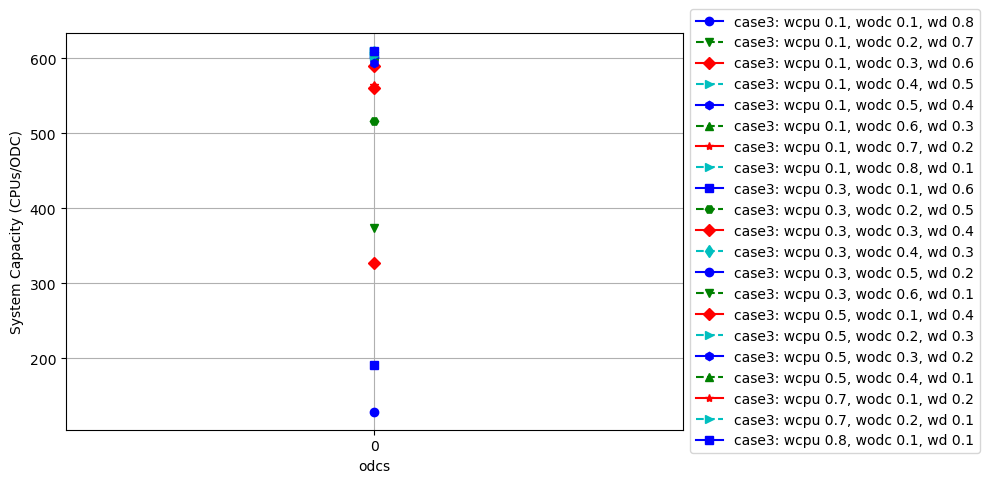

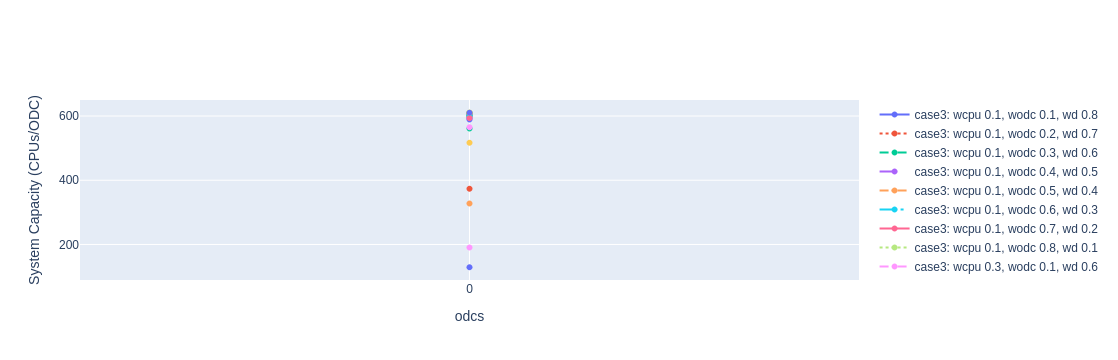

Graph:  Fiberlength-System
Config.Plot:  3 1 3


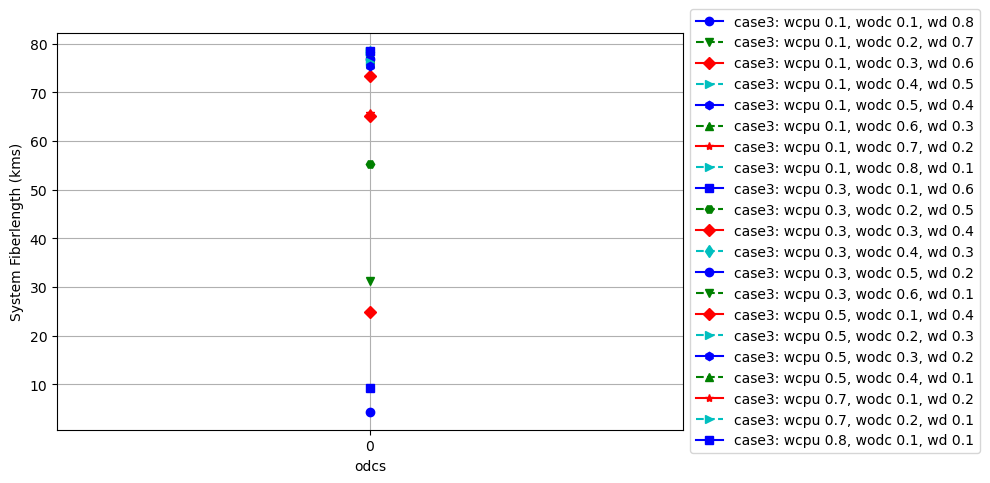

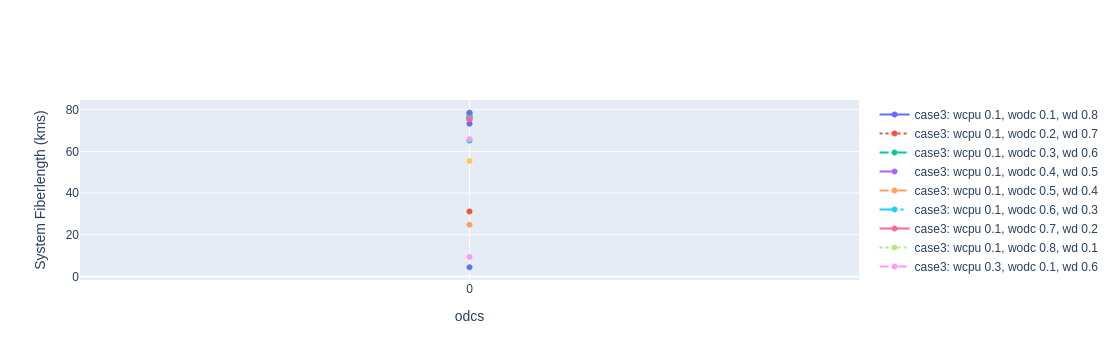

In [8]:
#Linux:
%cd $script_path
%run PlotCampaignScript -j "100" -l "MACRO" -g "System" -t "All" -m "All" -f "Placement_Manaus_Case_4.yaml" -p "/home/oai-ufrn/Repositories/open_ran_datacenter_placement/Results/results_Placement_Manaus_Case_4_odcs/" -sp '/home/oai-ufrn/Repositories/open_ran_datacenter_placement/PlotResults/'